### PbLi Simple

In [22]:
import openmc
import os, sys
from pathlib import Path
import numpy as np

# Import helper functions
sys.path.insert(0, f"{Path.cwd()}/helper")
from utilities import *

### Materials
PbLi density is 9.4 g/cm$^3$ with 90% Li-6 enrichment. In the PbLi, 17 atomic percent lithium to 83% lead. The system is a volume of 342 m$^3$ at 900 K. We increase tons of U in the system, subtracting PbLi, from 0 to 50 metric tons (MTU).

> [$\S$3] The blanket design examined here uses a lead–lithium eutectic (Pb–17Li) with 90% 6 Li enrichment.
>
> [$\S$4] Here, we assume a total system inventory of liquid lead–lithium of 10 000 metric tons, which
is generally considered a plausible value [13], and corresponds to a volume of 1.06 × 10 g/cm$^3$. 
>
> [$\S$4] We assume a particle size of 1 mm containing an 800 μm kernel coated with a 100 μm silicon-carbide layer. The average density of these particles would be about 7 g/cm$^3$ compared with 9.4 g/cm$^3$ of liquid lead–lithium, which potentially raises buoyancy issues that may have to be avoided in a practical design



In [23]:
""" USER SPECIFICATIONS
Nominal values used by Emma and Patrick + reasons
  DENSITY_PbLi : float : 9.4 [g/cc] : used by Glaser and Goldston
  DENSITY_TRISO   : float : 7 [g/cc] : used by Glaser and Goldston
  ENRICH_LI : float : 90 [wt%] : used by Glaser and Goldston
  ENRICH_U : float : 0.7204 [wt%] : natural uranium from PNNL-15870 
  TEMP_K : float : 900 [K]
  VOL_CC : float : 342,000,000 [cc = 342 m3]
  MASS_U_LIST : list of floats : 0, 0.1, 1, 2.5, 5, 10, 20, 30, 40, 50 [metric tons U]
"""
DENSITY_PbLi = 9.4 # g/cm3
DENSITY_TRISO = 7 # g/cm3

ENRICH_LI = 90 # 7.5 # wt%
ENRICH_U  = 0.7204 # wt% 
TEMP_K = 900 # K
VOL_CC = 342 * 1e6 # cm3
MASS_U_LIST = [0, 0.1, 0.2, 0.5, 1, 2.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # metric tons uranium (MTU)

In [24]:
""" MATERIALS """
# PbLi
pbli = openmc.Material() #83% Pb, 17% Li by atomic fraction
pbli.set_density('g/cm3', DENSITY_PbLi)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.17, enrichment=ENRICH_LI, enrichment_target='Li6', enrichment_type='wo') #Li-6 enrichment to 90%

# # metallic TRISO
# fuel = openmc.Material(name='Fuel')
# fuel.set_density('g/cm3', 19.01)
# fuel.add_element('U', 1.0)
# Mu238 = fuel.get_mass_density('U238') 
# Mfuel = fuel.density #used to compute mass fraction of U238 in fuel
# # #calculate total fuel mass given a mass of U238 (MASS_U_LIST)

# ceramic TRISO -- neglect buoyancy effects --ezoccoli 2025-07-07
#TRISO model from OpenMC examples
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)
Mu238 = fuel.get_mass_density('U238') 
Mfuel = fuel.density #used to compute mass fraction of U238 in fuel
#calculate total fuel mass given a mass of U238 (MASS_U_LIST)

#SiC FCI or structural inserts
#AND coating for TRISO
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

radius_fuel = 400e-4   # 400 μm = 0.0400 cm
radius_sic  = 500e-4   # 500 μm = 0.0500 cm
vol_tot  = (4/3) * np.pi * (radius_sic)**3
vol_fuel = (4/3) * np.pi * (radius_fuel)**3
vf_fuel = vol_fuel / vol_tot
vf_sic = 1.0 - vf_fuel


triso = openmc.Material.mix_materials([fuel, SiC], [vf_fuel, vf_sic], 'vo')
triso.set_density('g/cm3', DENSITY_TRISO)

f82h = openmc.Material(name='F82H Steel') #low-activation ferritic steel FS
f82h.set_density('g/cm3', 7.87)  # typical density
#https://www.tandfonline.com/doi/abs/10.1179/mst.1998.14.6.573
# Mass fractions from fusion blanket design literature
f82h.add_element('Fe', 0.88675)
f82h.add_element('Cr', 0.0780)
f82h.add_element('W', 0.020)
f82h.add_element('V', 0.0016)
f82h.add_element('Ti', 0.0002)
f82h.add_element('Mn', 0.0018)
f82h.add_element('C', 0.0009)
f82h.add_element('Si', 0.0013)
f82h.add_element('N', 0.00006)
f82h.add_element('P', 0.00004)
f82h.add_element('S', 0.00003)
f82h.add_element('Ni', 0.0004)
f82h.add_element('Mo', 0.0001)
f82h.add_element('Al', 0.0001)
f82h.add_element('Nb', 0.0001)
f82h.add_element('Ta', 0.0002)

he = openmc.Material(name='Helium')
he.set_density('g/cm3', 0.0001785)
he.add_element('He', 1)

# Calculate volume ratios of TRISO vs PbLi+structure, ensure they add up to 1
mix_list = []
for mtu in MASS_U_LIST:
    mass_fuel = mtu * 10**6 * (Mfuel / Mu238)
    V_fuel = mass_fuel / 10.5 #mass over fuel density
    V_triso = V_fuel / vf_fuel 
    vf_triso = V_triso / (VOL_CC * 0.805)
    vf_pbli = 1 - vf_triso
    pbliTRISO = openmc.Material.mix_materials([pbli, triso], [vf_pbli, vf_triso], 'vo') # fractions in 'mix_materials' MUST add up to 1
    pbliTRISO.volume = 0.805 * VOL_CC
    vf_pbliTRISO = 0.805
    vf_he = 0.097
    vf_f82h = 0.019
    vf_sic = 0.079 #volume fractions from Breeding Ch. 2 Table 1. Glaser and Goldston
    mix = openmc.Material.mix_materials([pbliTRISO, he, f82h, SiC],[vf_pbliTRISO, vf_he, vf_f82h, vf_sic],'vo')
    mix.name = 'Full PbLi + TRISO Blanket Homogenized'
    mix.temperature = TEMP_K
    mix.volume = VOL_CC
    mix_list.append(mix)
    print(mix.get_nuclide_atom_densities())
    print(mix.get_mass_density)
materials = openmc.Materials(mix_list)



{'Pb204': 0.0003060313196897918, 'Pb206': 0.005268110574659987, 'Pb207': 0.004830922975103142, 'Pb208': 0.01145431510838935, 'Li6': 0.004087815631262008, 'Li7': 0.00038940677383821694, 'U235': 0.0, 'U238': 0.0, 'O16': 0.0, 'C12': 0.0037561639317554283, 'C13': 4.207691206787456e-05, 'Si28': 0.0035036823781575232, 'Si29': 0.00017790699443055846, 'Si30': 0.00011727708575539654, 'He3': 5.2101295567184145e-12, 'He4': 2.605059568229651e-06, 'Fe54': 8.106484212126097e-05, 'Fe56': 0.00127254465765512, 'Fe57': 2.9388605723687246e-05, 'Fe58': 3.911083914148091e-06, 'Cr50': 5.30067542581756e-06, 'Cr52': 0.00010221824931043211, 'Cr53': 1.1590728934566774e-05, 'Cr54': 2.885177763419685e-06, 'W180': 3.75368712105342e-08, 'W182': 8.289392392326302e-06, 'W183': 4.476271891856203e-06, 'W184': 9.58441444908973e-06, 'W186': 8.893110404295728e-06, 'V50': 6.256145201755701e-09, 'V51': 2.4962019355005243e-06, 'Ti46': 2.5806598957242255e-08, 'Ti47': 2.3272860150531202e-08, 'Ti48': 2.3060151213671505e-07, 'Ti

In [25]:
# Get various specs for double-checking
# print(mix.get_nuclide_densities())
#print(triso.get_nuclide_atom_densities('U238'))
#print(f"Mix with {MASS_U_LIST[-1]} MTU")
#print(f"Mix density: {mix_list[-1].get_mass_density():.6f}")
print(Mu238, Mfuel)
print(f"U-238 number density: {mix_list[-1].get_nuclide_atom_densities('U238')}")
print(f"Li-6 number density: {mix_list[-1].get_nuclide_atom_densities('Li6')}")
print(f"U-238 mass: {pbliTRISO.get_mass('U238')}")
print(f"U-238 mass: {mix_list[-1].get_mass('U238')}")
print(f"Li-6 number density: {mix_list[-1].get_nuclide_atom_densities('Li6')}")

8.032995716102523 10.5
U-238 number density: {'U238': 0.0003731762214690655}
Li-6 number density: {'Li6': 0.003907309556779516}
U-238 mass: 50449723.24723246
U-238 mass: 50449723.247232445
Li-6 number density: {'Li6': 0.003907309556779516}


In [26]:
""" CROSS SECTIONS 
Temporary solution for finding xs files between WSL and Ubuntu on Computing Cluster without editing PATH --ppark 2025-06-28 
"""
xs_path_ubuntu = '/opt/openmc_data/endfb-viii.0-hdf5/cross_sections.xml'
xs_path_wsl   = '/mnt/c/openmc/data/endfb-viii.0-hdf5/cross_sections.xml'
if os.path.isfile(xs_path_ubuntu):
    materials.cross_sections = xs_path_ubuntu # use this on Zotacs --ppark
elif os.path.isfile(xs_path_wsl):
    materials.cross_sections = xs_path_wsl
else:
    print(f"Error finding cross section XML!")
    # sys.exit(2)

#### Geometry
For our simple case suppose we make a 1 m$^3$ cube with reflective surfaces of homogeneous FLiBe. 

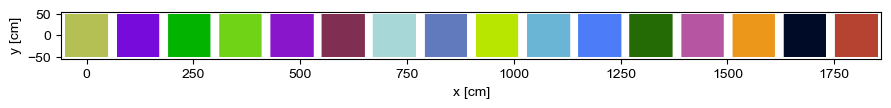

In [27]:
""" GEOMETRY """
cells, pitch, half_box = [], 120, 50 # +/- 50 cm bounds
box_centers = [pitch * i for i in range(len(MASS_U_LIST))] # used in Sources

for i, material in enumerate(mix_list):
    x_min = openmc.XPlane(x0= -half_box + box_centers[i], boundary_type='reflective')
    x_max = openmc.XPlane(x0=  half_box + box_centers[i], boundary_type='reflective')
    y_min, y_max = openmc.YPlane(-50, boundary_type='reflective'), openmc.YPlane( 50, boundary_type='reflective')
    z_min, z_max = openmc.ZPlane(-50, boundary_type='reflective'), openmc.ZPlane( 50, boundary_type='reflective')
    region = +x_min & -x_max & +y_min & -y_max & +z_min & -z_max
    
    cell = openmc.Cell(fill=material, region=region)
    cell.name = f"mix-{i+1}"
    cells.append(cell)

root_univ = openmc.Universe(cells=cells) # Create root universe with all material cells
root_univ.plot(width=(pitch * len(MASS_U_LIST), 110), origin=(pitch * (len(MASS_U_LIST) - 1) / 2, 0.0, 0.0)) # Visualize
geometry = openmc.Geometry(root_univ) # Set geometry

#### Settings
Here we define the other settings for our problem. 

In [28]:
""" TALLIES """
tallies = openmc.Tallies() # initialize

# Filters
cell_filter = openmc.CellFilter(cells)

E_bin_edges = logspace_per_decade(1e-5, 20e6, 100) # './helpers/utilities.py'
energy_filter = openmc.EnergyFilter(E_bin_edges)
# energy_filter = openmc.EnergyFilter([0., 0.625, 20.0e6])
# --Default thermal, intermediate, fast energy cutoffs in MCNP
# energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')
# --These have extra bins in key energy ranges. A full list of energy structures is available here: --ppark 2025-06-27
#   https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420
filters = [energy_filter, cell_filter]

# Flux tally
flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux'] # specific names required
flux_tally.filters = filters

# Uranium reaction rates
U_tally = openmc.Tally(name='uranium rxn rates')
U_tally.scores = ['(n,gamma)','fission', 'elastic'] # specific names required
U_tally.nuclides = ['U238', 'U235']
U_tally.filters = filters

# Lithium reaction rates
Li_tally = openmc.Tally(name='lithium rxn rates')
Li_tally.scores = ['(n,gamma)','(n,Xt)', 'elastic'] # specific names required
Li_tally.nuclides = ['Li6', 'Li7']
Li_tally.filters = filters

# Lead reaction rates
Pb_tally = openmc.Tally(name='lead rxn rates')
Pb_tally.scores = ['(n,gamma)','(n,2n)', 'elastic'] # specific names required
Pb_tally.nuclides = ['Pb204', 'Pb206', 'Pb207', 'Pb208']
Pb_tally.filters = filters

tallies.extend([flux_tally, U_tally, Li_tally, Pb_tally])


In [29]:
""" SETTINGS """
settings = openmc.Settings()

""" Source
Isotropic 14.07 MeV point source at center of each cube
"""
source = []
for p in box_centers:
    src = openmc.IndependentSource()
    src.space  = openmc.stats.Point((p,0,0))
    src.angle  = openmc.stats.Isotropic()
    src.energy = openmc.stats.Discrete([14.07e6], [1.0])
    source.append(src)
settings.source = source

""" Run type """
settings.run_mode = 'fixed source'
settings.particles = int(1e4)  #  len(MASS_U_LIST) *
settings.batches = 100

# settings.export_to_xml("./xml/settings.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

#### Run OpenMC
Don't run the `FLiBe-Plots.ipynb` if you plan on running OpenMC. Else you will get:
``` 
ERROR: Failed to open HDF5 file with mode ‘w’: summary.h5 
```
If you do, close all opened scripts, shut down all kernels, and then restart them.

In [31]:
model = openmc.model.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./model_PbLi1/")  
results_NSlow = model.run(cwd="./model_PbLi1/")  # PbLi with structural materials

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.3628e+00 seconds
   Reading cross sections          = 3.3398e+00 seconds
 Total time in simulation          = 1.3013e+02 seconds
   Time in transport only          = 1.2995e+02 seconds
   Time in active batches          = 1.3013e+02 seconds
   Time accumulating tallies       = 1.4613e-01 seconds
   Time writing statepoints        = 2.1807e-02 seconds
 Total time for finalization       = 4.8026e-01 seconds
 Total time elapsed                = 1.3399e+02 seconds
 Calculation Rate (active)         = 7684.37 particles/second

 ============================>     RESULTS     <============================

 Leakage Fraction            = 0.00000 +/- 0.00000

